In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
os.chdir(r"C:\Users\Gram\Desktop\스배데\데이콘 상점 신용카드 매출 예측 경진대회\data")
df = pd.read_csv('funda_train.csv')

In [3]:
df.store_id = df.store_id.astype(np.int32)
df.card_id = df.card_id.astype(np.int32)
df.card_company = df.card_company.astype('category')  # 카테고리형으로 바꾸면 메모리 용량 감소
df.transacted_date = pd.to_datetime(df.transacted_date + " " + df.transacted_time, format='%Y-%m-%d %H:%M') # transacted_date에 time합침
df.installment_term = df.installment_term.astype(np.int16)
df.region = df.region.astype('category')
df.type_of_business = df.type_of_business.astype('category')

del df['transacted_time']  # transacted_time은 transacted_date에 포함시켰으므로 삭제해도 됨

# amount는 float인데 float은 부동소수점을 공부하면 알겠지만 float을 줄이는 것은 정확도를 줄이는 것임
# float칼럼이 되게 많고, 메모리에 큰 영향을 끼치면 줄여야 하지만 정리해도 메모리 감소에 별 효과없음
# 즉, float은 칼럼이 여러개 있지 않은 이상 잘 건드리지 않음

In [4]:
df.head()

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01 13:13:00,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01 18:12:00,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01 18:52:00,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01 20:22:00,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02 11:06:00,0,NaN,기타 미용업,2000.000000


# 1. 분석적 관점에서 모델링
- 분석적으로 데이터를 상세하게 이해한 후 접근하는 방법
- 분석적 관점에서의 모델링 방법은 가설을 세움
   - 데이터가 어떻게 움직일 것이다, 데이터가 어떻게 분포할 것이라는 가설
   - 최근 3개월 간의 매출액이 feature가 되고 다른 feature만 추가하면 일반화가 가능해져 머신러닝, 딥러닝 적용 가능

## 가설 1 시간에 따른 매출 변동이 얼마나 클까?
- 최근 3개월이 미래 3개월과 비슷할 것이라는 예측으로 제출한 결과 점수가 높게 나옴
   - 이전 3개월과 이후 3개월이 많이 달라지는 것일까?라는 생각을 함
   - 즉, 시간에 따른 매출 변동이 얼마나 클까?
      - 어떤 상점은 2016년부터 매출이 발생하고, 어떤 상점은 2018년부터 발생했을 수 있음
      - 어떤 상점은 데이터가 거의 없을수도 있음
      - 어떤 상점은 폐업, 휴점했을 수도 있음

### 가설 1.1 각 상점 별로 데이터가 존재하는 기간은 어떻게 다를까?


In [5]:
# 상점 별로 데이터가 있었던 기간이 나옴(기간의 최대-최소)
store_period = df.groupby('store_id').transacted_date.max() - df.groupby('store_id').transacted_date.min()
store_period

store_id
0      1002 days 05:46:00
1      1002 days 02:46:00
2       989 days 01:03:00
4      1002 days 02:37:00
5      1002 days 04:34:00
              ...        
2132    919 days 06:23:00
2133    992 days 21:48:00
2134    840 days 07:59:00
2135    932 days 02:56:00
2136    647 days 06:23:00
Name: transacted_date, Length: 1967, dtype: timedelta64[ns]

In [6]:
# 깔끔하게 보기 위해 reset_index 해줌
store_period = (df.groupby('store_id').transacted_date.max() - df.groupby('store_id').transacted_date.min()).reset_index(name='period')
store_period

,store_id,period
0,0,1002 days 05:46:00
1,1,1002 days 02:46:00
2,2,989 days 01:03:00
3,4,1002 days 02:37:00
4,5,1002 days 04:34:00
...,...,...
1962,2132,919 days 06:23:00
1963,2133,992 days 21:48:00
1964,2134,840 days 07:59:00
1965,2135,932 days 02:56:00


In [7]:
import matplotlib.pyplot as plt  # 위에서는 판다스에서 존재하는 걸 사용했지만 이제는 옵션을 주기 위해 plt를 사용

plt.hist(store_period.period.dt.days)
plt.title('data exist period')
plt.xlabel('days')
plt.show()

# 대부분 상점들의 데이터 존재 기간이 1000일 정도임
# 일부 상점의 경우 600,700일 존재

<Figure size 640x480 with 1 Axes>

In [8]:
# 히스토그램으로 데이터가 작은 부분은 잘 안보이니 직접 확인해 봄
store_period.period.dt.days.nsmallest(10)
# 1950번 상점은 데이터가 340개 뿐

1950    340
1887    583
937     617
1189    638
1434    639
641     640
1796    640
1370    642
1864    642
655     643
Name: period, dtype: int64

**1950상점을 샘플로 직접 확인**

In [9]:
df[df.store_id ==1950]
# 2016년 8월 ~ 2019년 2월까지 데이터가 있는데 왜 데이터가 340개뿐이라고 나오지?
# 이 경우 코드를 잘못 구현했거나, 데이터를 제대로 이해하지 못했거나

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
5924203,1950,4211430,a,2016-08-12 16:41:00,0,NaN,NaN,14.285714
5924204,1950,4211430,a,2016-08-12 16:41:00,0,NaN,NaN,-14.285714
5924205,1950,4211430,a,2016-08-12 16:42:00,0,NaN,NaN,14.285714
5924206,1950,4211430,a,2016-08-12 16:43:00,0,NaN,NaN,-14.285714
5924207,1950,4211431,a,2016-08-16 08:39:00,0,NaN,NaN,857.142857
...,...,...,...,...,...,...,...,...
5927305,1950,4213194,c,2019-02-28 15:30:00,0,NaN,NaN,714.285714
5927306,1950,4213319,a,2019-02-28 17:01:00,0,NaN,NaN,571.428571
5927307,1950,4212770,b,2019-02-28 18:20:00,0,NaN,NaN,1714.285714
5927308,1950,4213320,c,2019-02-28 18:47:00,0,NaN,NaN,214.285714


In [10]:
# 문제점의 원인은 인덱스 번호를 상점 번호로 착각한 것
store_period.nsmallest(5,'period')
# 1950은 인덱스 번호이고 2119가 상점 번호임

,store_id,period
1950,2119,340 days 21:25:00
1887,2053,583 days 01:50:00
937,999,617 days 00:24:00
1189,1283,638 days 21:39:00
1434,1553,639 days 00:02:00


In [11]:
df[df.store_id ==2119]
# 2017~2018년까지 데이터가 있고, 2018년 이후 데이터가 없음 -> 이후 3개월동안도 매출없을 것이란 생각이 듬 => 폐점한 것으로 보이는 케이스

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
6492743,2119,4629260,c,2017-03-23 14:45:00,0,NaN,NaN,275000.000000
6492744,2119,4629261,a,2017-03-27 11:31:00,0,NaN,NaN,114285.714286
6492745,2119,2171166,d,2017-03-27 11:58:00,0,NaN,NaN,148571.428571
6492746,2119,4629262,d,2017-03-28 11:13:00,0,NaN,NaN,78571.428571
6492747,2119,4629263,a,2017-03-28 11:19:00,0,NaN,NaN,112000.000000
...,...,...,...,...,...,...,...,...
6492850,2119,4629273,c,2018-02-12 13:34:00,0,NaN,NaN,60000.000000
6492851,2119,4629260,c,2018-02-20 12:16:00,0,NaN,NaN,296428.571429
6492852,2119,4629276,d,2018-02-20 15:33:00,0,NaN,NaN,110000.000000
6492853,2119,4629261,a,2018-02-26 13:22:00,0,NaN,NaN,122857.142857


**최근에 생긴 상점의 데이터 존재 기간 확인**

In [12]:
df.store_id.max()

2136

In [13]:
df[df.store_id ==2136]
# 상점번호 중 2236이 제일 큰 숫자 였음 -> 번호가 클 수록 최근에 생긴 상점일 수 있어 데이터가 최신것만 존재할 가능성 있음
# 실제로 2017년부터 시작함

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
6547641,2136,4535759,d,2017-05-22 17:31:00,0,제주 제주시,기타 주점업,1857.142857
6547642,2136,4535759,d,2017-05-22 17:31:00,0,제주 제주시,기타 주점업,-1857.142857
6547643,2136,4535759,d,2017-05-22 17:42:00,0,제주 제주시,기타 주점업,9142.857143
6547644,2136,4535759,d,2017-05-22 17:42:00,0,제주 제주시,기타 주점업,-9142.857143
6547645,2136,4658439,c,2017-05-23 00:14:00,0,제주 제주시,기타 주점업,5000.000000
...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28 23:20:00,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28 23:27:00,0,제주 제주시,기타 주점업,571.428571


**인덱스에 대한 개념 -> 면접에서 꼭 물어보는 질문, 이걸 모르면 판다스의 이용성이 저하됨**
- DB인덱스와 비슷한 개념
- 자료구조 중 딕셔너리 키는 해쉬구조로 되어있음
   - 키가 해쉬함수로 가므로 유일해야함 = 중복미존재
   - 각 키에 대한 접근 시간복잡도가 1위
   - 즉, 딕셔너리 크기에 상관없이 임의의 키에 대해 빠르게 접근할 수 있다는 것
   - 판다스 딕셔너리도 동일한 성질이 적용됨
      - ordered 딕셔너리라고 함, 순서가 존재하는 딕셔너리라는 뜻
          - 2119로 2119상점의 모든 데이터를 뽑는 시간 6.97초
          - 2119의 인덱스 번호로 2119데이터를 뽑는 시간 1초 -> 훨씬 빠름
          - 즉, 원하는 행만을 빠르게 뽑아낼 수 있다는 뜻
          - 2119가 중복없이 1개 데이터만 있었다면 더 빠를 것
          - 즉, 중복이 존재하면 느려짐

**예시**

In [54]:
# 임시로 df에서 인덱스와 store_id를 가지고 딕셔너리를 만듬
dic = {idx:row.store_id for idx, row in df.head(30).iterrows()}
dic
# 자료구조 중 딕셔너리 키는 해쉬구조로 되어있음
# 키가 해쉬함수로 가므로 유일해야함 = 중복미존재
# 각 키에 대한 접근은 시간복잡도가 1위
# 즉, 딕셔너리 크기에 상관없이 임의의 키에 대해 빠르게 접근할 수 있다는 것

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0}

In [55]:
# 상점번호로 데이터를 가져옴
%%time
df[df.store_id==2119]
# 6.7초 걸림

UsageError: Line magic function `%%time` not found.


In [56]:
# 인덱스번호로 데이터를 가져옴
%%time
df.loc[6492744] 
# 1.06초로 상점번호로 가져오는 것보다 훨씬 빠름
# 실무에서는 데이터 양이 많으므로 임의의 행에 대해 빠르게 로우로 찔러들어갈 수 있음 -> 문제는 중복이 없어야만 함

UsageError: Line magic function `%%time` not found.


**만약 중복이 존재한다면?**

In [57]:
# inplace는 권장하지 않음
temp_df = df.copy()

In [58]:
# store_id를 인덱스로 함
temp_df = temp_df.set_index('store_id')

In [59]:
%%time
temp_df.loc[2119] # 상점번호를 인덱스로하면 바로 가져올 수 있음
# 2119는 중복이 있으므로 느림
# 2119상점이 데이터 1줄만 있었다면 더 빠르게 나왔을 것

Wall time: 82.8 ms


,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
store_id,,,,,,,
2119,4629260,c,2017-03-23 14:45:00,0,NaN,NaN,275000.000000
2119,4629261,a,2017-03-27 11:31:00,0,NaN,NaN,114285.714286
2119,2171166,d,2017-03-27 11:58:00,0,NaN,NaN,148571.428571
2119,4629262,d,2017-03-28 11:13:00,0,NaN,NaN,78571.428571
2119,4629263,a,2017-03-28 11:19:00,0,NaN,NaN,112000.000000
...,...,...,...,...,...,...,...
2119,4629273,c,2018-02-12 13:34:00,0,NaN,NaN,60000.000000
2119,4629260,c,2018-02-20 12:16:00,0,NaN,NaN,296428.571429
2119,4629276,d,2018-02-20 15:33:00,0,NaN,NaN,110000.000000


### 가설1.2 휴점을 오래하는 상점이 있는가? 즉, 데이터가 끊겼다가 다시 발생하는 게 흔한 일인가?

In [14]:
df.sort_values('transacted_date') # 혹시 모르니 정렬시켜 둠

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
3314317,1091,2352113,f,2016-06-01 00:00:00,0,NaN,NaN,2428.571429
1116192,410,752611,b,2016-06-01 00:00:00,0,NaN,NaN,77142.857143
1712884,611,1184314,a,2016-06-01 00:00:00,0,서울 송파구,NaN,6571.428571
4902523,1609,3487137,b,2016-06-01 00:00:00,0,부산 사상구,NaN,7000.000000
1468641,534,1013865,a,2016-06-01 00:00:00,0,서울 서초구,NaN,11428.571429
...,...,...,...,...,...,...,...,...
5541618,1824,3938087,f,2019-02-28 23:58:00,0,NaN,NaN,4000.000000
5520065,1819,3923665,e,2019-02-28 23:58:00,0,부산 기장군,간이음식 포장 판매 전문점,2285.714286
1406927,513,972680,b,2019-02-28 23:59:00,0,NaN,NaN,54142.857143
3284999,1074,2315288,b,2019-02-28 23:59:00,0,NaN,NaN,6285.714286


In [15]:
from tqdm import tqdm # 작동 시간을 보여줌

**지금은 코드 개발이 아닌 결과를 빨리 내는 것이 초점이므로 멀티프로세싱 사용**
- 기본적으로 코어를 1개 쓰는데 코어를 여러개 사용하는 것
- n_jobs=14는 코어 14개 사용

In [16]:
# lambda는 유저 정의 함수를 간단히 사용하게 해줌
max_time_diff = lambda group: (group.store_id.values[0], group.transacted_date.diff().max()) # store_id도 반환하도록 함

In [17]:
from joblib import Parallel, delayed   # 멀티프로세싱 라이브러리(사이킷런에서 많이 씀)
res = Parallel(n_jobs=14)(delayed(max_time_diff)(group)  # 16개 코어 중 14개 사용
                         for _, group in tqdm(df.groupby('store_id'), total=df.store_id.nunique()))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:34<00:00, 56.69it/s]


In [18]:
max_diff_df = pd.DataFrame(res, columns=['store_id', 'max_diff']) # 데이터프레임으로 만들어 줌
max_diff_df

,store_id,max_diff
0,0,6 days 15:49:00
1,1,10 days 19:35:00
2,2,36 days 19:32:00
3,4,3 days 17:32:00
4,5,8 days 20:06:00
...,...,...
1962,2132,3 days 23:52:00
1963,2133,53 days 17:13:00
1964,2134,85 days 00:48:00
1965,2135,8 days 21:54:00


In [19]:
max_diff_df.nlargest(10, 'max_diff')
# 795상점은 656일 휴무

,store_id,max_diff
742,795,656 days 21:07:00
1117,1204,554 days 17:15:00
590,632,518 days 14:52:00
251,271,492 days 01:49:00
1912,2081,485 days 02:40:00
1563,1696,462 days 19:57:00
1691,1836,386 days 02:41:00
469,506,317 days 20:46:00
1643,1783,306 days 17:02:00
1260,1364,288 days 01:58:00


In [20]:
import datetime
print(f"100일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: {(max_diff_df.max_diff>datetime.timedelta(days=100)).sum()}")
# 총 상점 수가 2000개 였는데 69개면 적지 않음

100일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 69


In [21]:
max_diff_df.max_diff>datetime.timedelta(days=100)  
# max_diff가 datetime의 timedelta타입임
# 결과는 불린으로 나옴

0       False
1       False
2       False
3       False
4       False
        ...  
1962    False
1963    False
1964    False
1965    False
1966    False
Name: max_diff, Length: 1967, dtype: bool

**데이터 재확인**

In [22]:
for days in (10, 50, 90, 150, 300):
    print(f"{days}일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: {(max_diff_df.max_diff>datetime.timedelta(days=days)).sum()}")

# 10일이상은 959개로 흔한 일
# 50일 이상도 159나 있으나 드문 일은 아님

10일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 959
50일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 159
90일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 83
150일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 36
300일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 9


### 가설1.3 한 달 단위로 매출량 진폭은 클까? 최근 3개월 데이터를 얼마나 믿을 수 있을까?

- 상당 수의 상점들이 풀로 데이터가 있고, 10일이상 쉬는 건 흔한 일
- 하루 단위로 매출량을 보면 진폭이 클 것 같아 한 달 단위로 매출량을 확인해보고자 함

**유니크한 store_id 중 10개만 추출**

In [23]:
sampled_stores = df.store_id.drop_duplicates().sample(5) 
sampled_stores

550995      179
5866432    1933
1688477     601
1922946     672
4847206    1592
Name: store_id, dtype: int32

In [24]:
sampled_df = df[df.store_id.isin(sampled_stores)]
sampled_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
550995,179,372179,b,2016-06-08 18:07:00,0,인천 계양구,NaN,60000.000000
550996,179,372180,a,2016-06-09 16:18:00,0,인천 계양구,NaN,68571.428571
550997,179,372181,h,2016-06-09 18:23:00,0,인천 계양구,NaN,68571.428571
550998,179,372182,c,2016-06-09 18:27:00,0,인천 계양구,NaN,68571.428571
550999,179,372183,f,2016-06-10 18:59:00,0,인천 계양구,NaN,34285.714286
...,...,...,...,...,...,...,...,...
5871676,1933,4172654,a,2019-02-28 13:30:00,0,전북 전주시,한식 음식점업,56000.000000
5871677,1933,4172744,f,2019-02-28 13:32:00,0,전북 전주시,한식 음식점업,5857.142857
5871678,1933,4172788,b,2019-02-28 13:43:00,0,전북 전주시,한식 음식점업,9571.428571
5871679,1933,4172789,a,2019-02-28 20:15:00,0,전북 전주시,한식 음식점업,9285.714286


**월별로 보기 위해 month생성**


In [25]:
# 월 별로
sampled_df['transacted_month'] = sampled_df.transacted_date.dt.month
# 아래 에러코드는 새로운 칼럼 할당을 무식하게 해서 그러함

# loc을 이용해서 하라는 뜻
# sampled_df.loc[:, 'transacted_month'] = sampled_df.transacted_date.dt.month

# 혹은 새로 assign이용(이게 가장 좋음)
# sampled_df = sampled_df.assign(transacted_month = sampled_df.transacted_date.dt.month)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# 에러가 났으니 assign을 사용해 코드 수정
sampled_df = sampled_df.assign(transacted_month = sampled_df.transacted_date.dt.month)

In [27]:
# 상점 별로 월별로 나옴
sampled_grouped = sampled_df.groupby(['store_id', 'transacted_month']).amount.sum().reset_index(name='amount')
sampled_grouped
# 생각해보니 월 별로 하면 3년치라 월이 많이 반복됨

,store_id,transacted_month,amount
0,179,1,2.490771e+06
1,179,2,2.601971e+06
2,179,3,1.803714e+06
3,179,4,1.698200e+06
4,179,5,1.705343e+06
5,179,6,2.822286e+06
6,179,7,3.311443e+06
7,179,8,3.290186e+06
8,179,9,3.379486e+06
9,179,10,3.272071e+06


**좀 더 쉽게 보기위해 년도+월별로 수정**

In [28]:
sampled_df.transacted_date.dt.to_period("M")

550995     2016-06
550996     2016-06
550997     2016-06
550998     2016-06
550999     2016-06
            ...   
5871676    2019-02
5871677    2019-02
5871678    2019-02
5871679    2019-02
5871680    2019-02
Name: transacted_date, Length: 12986, dtype: period[M]

In [29]:
sampled_df =  sampled_df.assign(transacted_month = sampled_df.transacted_date.dt.to_period("M"))

In [30]:
sampled_grouped = sampled_df.groupby(['store_id', 'transacted_month']).amount.sum().reset_index(name='amount')
sampled_grouped
# 년도+월별

,store_id,transacted_month,amount
0,179,2016-06,1.301571e+06
1,179,2016-07,1.606729e+06
2,179,2016-08,1.479786e+06
3,179,2016-09,1.458514e+06
4,179,2016-10,1.436071e+06
...,...,...,...
160,1933,2018-10,1.164571e+06
161,1933,2018-11,1.046000e+06
162,1933,2018-12,1.807429e+06
163,1933,2019-01,1.362571e+06


**년도+월별 시각화**

In [31]:
# 상점별로 그룹화해 봄
for store_id, group in sampled_grouped.groupby('store_id'):
    break

In [55]:
#import matplotlib.pyplot as plt
#plt.plot(group.transacted_month, group.amount)
# 그림이 안 예쁘니 다듬기로

In [40]:
# 다듬음
#plt.figure(figsize=(20,8))
#leg = []   # legend하면 범례가 생김
#for store_id, group in sampled_grouped.groupby('store_id'):
    #plt.plot(group.transacted_month, group.amount)
    #leg.append(store_id)
#plt.legend(leg)
#plt.show()

# 변동이 생각보다 심하진 않음
# 변동이 크다는 기준은 로켓성장을 한다거나, 대박이나 쪽박치는 케이스가 보이지 않음
# 그래프가 주식과 같아보임 아마 주식도 수요예측이라 그럴수도

# 그래프를 보아하니 최근 3개월 데이터가 믿을 수 있는 것 같음 -> 2가지를 발전시켜 보도록 함

**2가지를 새로 발전시킴**

- 최근 1개월을 확인해보자
- type of business별로 나눠보자

## 가설 2 type of business 별로 판매액이 다른가?


### 상점별 월별 판매액이 업종별로 같은가?


**업종별 상점 판매량의 평균**

In [33]:
df.groupby('type_of_business').mean()
# 이렇게 mean을 하면 안됨
# 왜냐면 한의원은 최근에 폐장 수가 많아 기간이 짧고 길 수 있음
# 즉, 유형별로 차이가 클 수 있음

,store_id,card_id,installment_term,amount
type_of_business,,,,
가구 소매업,1272.566565,2.716988e+06,1.733131,67732.033782
가전제품 소매업,1621.469949,3.437347e+06,0.726065,32496.871899
가정용 세탁업,369.576750,7.740620e+05,0.019922,3405.912195
가정용 직물제품 소매업,734.939959,1.469000e+06,0.782806,21102.323045
간이음식 포장 판매 전문점,799.331081,1.664090e+06,0.067800,5493.173995
...,...,...,...,...
한의원,848.000000,1.804422e+06,0.102431,4806.961793
화장품 및 화장용품 도매업,945.663385,2.012980e+06,1.412574,41518.607498
"화장품, 비누 및 방향제 소매업",915.433028,1.928082e+06,0.498408,17276.433345


**상점별 업종 판매량의 합**

In [34]:
df.groupby(['store_id','type_of_business']).amount.sum()
# 이 코드는 상점별로 amount가 얼마인가를 확인하는 것

store_id  type_of_business 
0         가구 소매업              NaN
          가전제품 소매업            NaN
          가정용 세탁업             NaN
          가정용 직물제품 소매업        NaN
          간이음식 포장 판매 전문점      NaN
                               ..
2136      한의원                 NaN
          화장품 및 화장용품 도매업      NaN
          화장품, 비누 및 방향제 소매업   NaN
          화초 및 식물 소매업         NaN
          화훼류 및 식물 도매업        NaN
Name: amount, Length: 285215, dtype: float64

In [35]:
df.groupby(['store_id','type_of_business']).amount.sum().dropna()
# 이렇게 해야 상점별 판매액의 총합을 볼 수 있음
# 이것도 문제가 있음 -> 기준이 다 다르므로
# 따라서 월별로 다시 확인

store_id  type_of_business    
0         기타 미용업                  2.417447e+07
5         의복 액세서리 및 모조 장신구 도매업    1.086164e+07
8         한식 음식점업                 2.680906e+07
12        배관 및 냉ㆍ난방장치 도매업         7.995197e+06
14        그 외 기타 스포츠시설 운영업        1.200774e+08
                                      ...     
2125      한식 음식점업                 8.357507e+07
2126      간이음식 포장 판매 전문점          2.429629e+06
2128      의복 소매업                  1.755557e+07
2130      비알코올 음료점업               2.874914e+06
2136      기타 주점업                  5.090033e+07
Name: amount, Length: 792, dtype: float64

**상점별 월별 업종별 판매량**

In [36]:
df = df.assign(transacted_month = df.transacted_date.dt.to_period("M").dt.to_timestamp())

In [37]:
# 이렇게 코드가 길어지는 것을 메소드 체이닝이라고 함
business_group = df.groupby(['store_id', 'transacted_month']).amount.sum().dropna().reset_index(name='amount') # 상점별 월 판매금액 합
business_group = business_group.groupby('store_id').amount.mean().reset_index(name='amount') # 상점별 월 평균 판매금액

In [38]:
business_group = business_group.merge(df[['store_id', 'type_of_business']].drop_duplicates().dropna(), on='store_id')
business_group

,store_id,amount,type_of_business
0,0,7.325597e+05,기타 미용업
1,5,3.291407e+05,의복 액세서리 및 모조 장신구 도매업
2,8,9.574663e+05,한식 음식점업
3,12,2.498499e+05,배관 및 냉ㆍ난방장치 도매업
4,14,3.638710e+06,그 외 기타 스포츠시설 운영업
...,...,...,...
787,2125,2.532578e+06,한식 음식점업
788,2126,1.104377e+05,간이음식 포장 판매 전문점
789,2128,5.319870e+05,의복 소매업
790,2130,8.711861e+04,비알코올 음료점업


In [47]:
business_group_amount = business_group.groupby('type_of_business').amount.mean()
business_group_amount
# 쉽게 알아볼 수 없으니 그래프화하도록

type_of_business
가구 소매업               2.250893e+06
가전제품 소매업             2.271011e+06
가정용 세탁업              3.585084e+05
가정용 직물제품 소매업         1.405862e+06
간이음식 포장 판매 전문점       7.165532e+05
                         ...     
한의원                  6.470462e+05
화장품 및 화장용품 도매업       1.606644e+06
화장품, 비누 및 방향제 소매업    8.375633e+05
화초 및 식물 소매업          4.889491e+05
화훼류 및 식물 도매업         9.074083e+05
Name: amount, Length: 145, dtype: float64

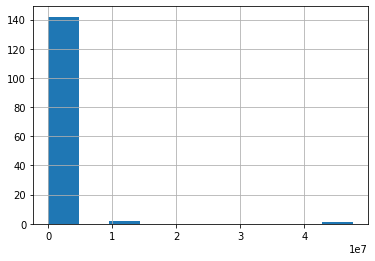

In [48]:
business_group.groupby('type_of_business').amount.mean().hist()
# 일부 상점들이 대부분을 차지함

**e소수점으로 표시되는거 변경함**

In [49]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [50]:
business_group_amount = business_group_amount.reset_index(name='amount')

In [51]:
business_group_amount.nlargest(10, 'amount')
# 의약품이 많이 팔림

,type_of_business,amount
101,의약품 도매업,47531520.03
106,일반 병원,10937807.79
36,기타 산업용 농산물 도매업,9665114.72
83,안경 및 안경렌즈 제조업,4249680.09
69,속옷 및 잠옷 소매업,3902221.21
64,상품 종합 도매업,3605705.85
135,"페인트, 창호 및 기타 건설자재 소매업",3507135.93
9,경영 컨설팅업,3398826.02
87,여행사업,2759418.17
70,수산물 가공식품 도매업,2731020.76


### 업종별로 상점이 몇가지 있는가?


In [52]:
business_group_amount = (
    business_group_amount.merge(
        df.groupby('type_of_business').store_id.nunique().reset_index(name='store_count')
        , on='type_of_business')
)

In [53]:
business_group_amount.nlargest(10, 'amount')
# 의약품도매업이 1개 밖에 없는데 차지하는 양이 큼 -> 산업군 특성일 듯

,type_of_business,amount,store_count
101,의약품 도매업,47531520.03,1
106,일반 병원,10937807.79,1
36,기타 산업용 농산물 도매업,9665114.72,1
83,안경 및 안경렌즈 제조업,4249680.09,1
69,속옷 및 잠옷 소매업,3902221.21,1
64,상품 종합 도매업,3605705.85,2
135,"페인트, 창호 및 기타 건설자재 소매업",3507135.93,1
9,경영 컨설팅업,3398826.02,1
87,여행사업,2759418.17,2
70,수산물 가공식품 도매업,2731020.76,1


# 2. 피처 엔지니어링 
- 미래 3개월을 최근 3개월이 정답인것처럼 취급해서 예측하기로 함


- 최근 1개월 : feature1
- type_of_business별로 : feature2
- 평균 할부 개월수 installment_term : feature3
- 최빈 카드사 card_company(상점별로 여러 카드사가 있으니 최빈 카드사로) : feature 4
- card_id는 개인 식별이라 제외


## 2.1 train, test 분리
- 현재 문제점은 지금 데이터가 학습과 테스트로 나눠져 있지 않음
- 최근 3개월을 정답으로 간주하기로 함

In [39]:
import datetime
train_df = df[df.transacted_date < datetime.date(2018, 11, 1)]
test_df = df[~(df.transacted_date < datetime.date(2018, 11, 1))]
# < 이므로 2018.12.1이 아닌 2018.11.1해야 12월,1월,2월이 선택됨

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
train_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
0,0,0,b,2016-06-01 13:13:00,0,NaN,기타 미용업,1857.142857,2016-06-01
1,0,1,h,2016-06-01 18:12:00,0,NaN,기타 미용업,857.142857,2016-06-01
2,0,2,c,2016-06-01 18:52:00,0,NaN,기타 미용업,2000.000000,2016-06-01
3,0,3,a,2016-06-01 20:22:00,0,NaN,기타 미용업,7857.142857,2016-06-01
4,0,4,c,2016-06-02 11:06:00,0,NaN,기타 미용업,2000.000000,2016-06-01
...,...,...,...,...,...,...,...,...,...
6555176,2136,4661875,e,2018-10-31 01:38:00,0,제주 제주시,기타 주점업,8142.857143,2018-10-01
6555177,2136,4663007,a,2018-10-31 19:20:00,0,제주 제주시,기타 주점업,2857.142857,2018-10-01
6555178,2136,4662457,d,2018-10-31 22:07:00,0,제주 제주시,기타 주점업,3285.714286,2018-10-01
6555179,2136,4663008,c,2018-10-31 23:19:00,0,제주 제주시,기타 주점업,10714.285714,2018-10-01


In [41]:
test_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
3979,0,1585,f,2018-11-01 19:06:00,0,NaN,기타 미용업,2000.000000,2018-11-01
3980,0,722,c,2018-11-02 10:53:00,0,NaN,기타 미용업,2000.000000,2018-11-01
3981,0,1642,c,2018-11-03 13:19:00,0,NaN,기타 미용업,7142.857143,2018-11-01
3982,0,1341,b,2018-11-03 13:20:00,0,NaN,기타 미용업,17142.857143,2018-11-01
3983,0,1396,g,2018-11-03 14:12:00,0,NaN,기타 미용업,428.571429,2018-11-01
...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28 23:20:00,0,제주 제주시,기타 주점업,-4500.000000,2019-02-01
6556609,2136,4663855,d,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4142.857143,2019-02-01
6556610,2136,4663489,a,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4500.000000,2019-02-01
6556611,2136,4663856,d,2019-02-28 23:27:00,0,제주 제주시,기타 주점업,571.428571,2019-02-01


In [42]:
y = test_df.groupby('store_id').amount.sum()
y

store_id
0       2.748714e+06
1       3.917857e+05
2       1.430857e+06
4       3.634000e+06
5       1.321386e+06
            ...     
2132    2.405714e+06
2133    2.850000e+05
2134    4.405000e+05
2135    1.997857e+06
2136    8.663929e+06
Name: amount, Length: 1956, dtype: float64

## 2.2 feature 1 - 최근 1개월

**최근 1개월 기간 설정**

In [43]:
recent_df = train_df[train_df.transacted_date >= datetime.datetime(2018, 10, 1)]
recent_df
# train_df는 2018.11월까지로 설정했으므로 최근 1개월은 2018.11월임

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
3853,0,1584,a,2018-10-01 15:58:00,0,NaN,기타 미용업,2142.857143,2018-10-01
3854,0,1585,f,2018-10-01 19:12:00,0,NaN,기타 미용업,2000.000000,2018-10-01
3855,0,496,a,2018-10-03 12:45:00,0,NaN,기타 미용업,7142.857143,2018-10-01
3856,0,1586,b,2018-10-03 16:49:00,0,NaN,기타 미용업,12857.142857,2018-10-01
3857,0,1587,a,2018-10-03 19:21:00,0,NaN,기타 미용업,9714.285714,2018-10-01
...,...,...,...,...,...,...,...,...,...
6555176,2136,4661875,e,2018-10-31 01:38:00,0,제주 제주시,기타 주점업,8142.857143,2018-10-01
6555177,2136,4663007,a,2018-10-31 19:20:00,0,제주 제주시,기타 주점업,2857.142857,2018-10-01
6555178,2136,4662457,d,2018-10-31 22:07:00,0,제주 제주시,기타 주점업,3285.714286,2018-10-01
6555179,2136,4663008,c,2018-10-31 23:19:00,0,제주 제주시,기타 주점업,10714.285714,2018-10-01


**최근 1개월 간 상점 판매량 합**

In [44]:
recent_amount = recent_df.groupby(['store_id']).amount.sum().reset_index(name='amount').dropna()
recent_amount

# amount에 NaN이 있을 것임
# 상점 유형이 카테고리형이어서 상점id별로 모든 유형을 찾음 -> 카테고리형은 이런부분 신경써줘야 함 
# NaN을 없애기 위해 dropna해 줌

,store_id,amount
0,0,7.390000e+05
1,1,9.500000e+04
2,2,5.100000e+05
3,4,8.284286e+05
4,5,3.249286e+05
...,...,...
1937,2132,9.385714e+05
1938,2133,1.927000e+05
1939,2134,8.442857e+04
1940,2135,8.504286e+05


## 2.3 feature 2 - type_of_business

In [45]:
# 상점 유형이 여러개일 경우가 있는지 확인 -> 업종 변경할 경우
# 카드사의 경우 업종별로 수수료가 다름. 카드를 설치하는 벤더사에서 일부러 주류로 안하고 음식점으로 해주는 경우도 있음
df.groupby('store_id').type_of_business.nunique().nlargest(10)
# 다행히 각 상점 별로 분야는 최대 1개

store_id
0     1
5     1
8     1
12    1
14    1
17    1
18    1
19    1
23    1
24    1
Name: type_of_business, dtype: int64

**위의 코드 정리**

In [46]:
assert df.groupby('store_id').type_of_business.nunique().max() == 1 # 각 상점 별로 분야는 최대 1개

In [47]:
store_business_type = train_df[['store_id', 'type_of_business']].drop_duplicates().dropna()
store_business_type

# amount에 NaN이 있을 것임
# 상점 유형이 카테고리형이어서 상점id별로 모든 유형을 찾음 -> 카테고리형은 이런부분 신경써줘야 함 
# NaN을 없애기 위해 dropna해 줌

,store_id,type_of_business
0,0,기타 미용업
14677,5,의복 액세서리 및 모조 장신구 도매업
26837,8,한식 음식점업
37584,12,배관 및 냉ㆍ난방장치 도매업
42528,14,그 외 기타 스포츠시설 운영업
...,...,...
6505557,2125,한식 음식점업
6514524,2126,간이음식 포장 판매 전문점
6519952,2128,의복 소매업
6526704,2130,비알코올 음료점업


## 2.4 feature3 - installment_term
- 평균 할부 개월 수

In [48]:
installment = train_df.groupby('store_id').installment_term.mean().reset_index(name='installment')
installment

,store_id,installment
0,0,0.115356
1,1,0.000000
2,2,0.220703
3,4,0.038237
4,5,0.197383
...,...,...
1962,2132,0.003953
1963,2133,0.076006
1964,2134,0.008380
1965,2135,0.003505


- 판다스에 존재하는 api는 우리가 어떻게 짜도 결과를 빨리 내보낼 수 있도록 되어있음
- 즉, 최적화되어 있어 빠름
- 근데 여기에 다른 것을 끼얹으면?
  - df.amount + 1 => 최적화라 빠름
  - df.amount.apply(lambda x:x+1) => 느림
  - 즉, aggregation함수는 괜찮지만 lambda가 들어가면 느려질 확률 높음
  - 따라서 함수를 찾을 때 이 점을 유의해서 찾을 것
  - 이렇게 최적화되어 있는 api는 내부적으로 벡터라이제이션을 이용한 경우임<br><br>

- 벡터라이제이션
    - cpu에 명령을 줄 때
        
         - al랑 b을 가지고 c를 해
         - a2랑 b2을 가지고 c를 해
         - a3랑 b3을 가지고 c를 해
         - a4랑 b4을 가지고 c를 해<br><br>
         - c를 할 거야
             - a1과 b1를 가지고
             - a1과 b1를 가지고
             - a1과 b1를 가지고
             - a1과 b1를 가지고<br><br>
    - 결과물은 2번째가 더 빠를 것임
    - 어떤 연산을 할지 미리 알려주고, 정보전달 내용도 적으므로

## 2.5 feature4 - card_company 
- 최빈 카드사

In [49]:
store_most_card = train_df.groupby('store_id')['card_company'].agg(pd.Series.mode).reset_index(name='card_company')
store_most_card 
# 최빈값이 여러 개일 경우 중복이 있을 수 있음

,store_id,level_1,card_company
0,0,0,a
1,1,0,a
2,2,0,a
3,4,0,a
4,5,0,b
...,...,...,...
1966,2132,0,a
1967,2133,0,a
1968,2134,0,d
1969,2135,0,a


In [50]:
store_most_card = store_most_card.drop_duplicates('store_id')
store_most_card

,store_id,level_1,card_company
0,0,0,a
1,1,0,a
2,2,0,a
3,4,0,a
4,5,0,b
...,...,...,...
1966,2132,0,a
1967,2133,0,a
1968,2134,0,d
1969,2135,0,a


In [51]:
del store_most_card['level_1'] 
store_most_card 
# 모르는 열이 추가되 삭제

,store_id,card_company
0,0,a
1,1,a
2,2,a
3,4,a
4,5,b
...,...,...
1966,2132,a
1967,2133,a
1968,2134,d
1969,2135,a


In [52]:
# 제대로 코드를 구현했는지 확인
df[df.store_id == 5].card_company.value_counts()

b    421
a    407
c    391
e    266
d    209
f    135
g     82
h     47
Name: card_company, dtype: int64

In [53]:
# 제대로 코드를 구현했는지 확인
df[df.store_id == 2113].card_company.value_counts()

a    2219
b    1609
c    1026
d     914
g     473
e     315
f     233
h     136
Name: card_company, dtype: int64

## 2.6 튜닝된 피처 확인

**상점별로 최근 1개월간 판매량**

In [54]:
recent_amount

,store_id,amount
0,0,7.390000e+05
1,1,9.500000e+04
2,2,5.100000e+05
3,4,8.284286e+05
4,5,3.249286e+05
...,...,...
1937,2132,9.385714e+05
1938,2133,1.927000e+05
1939,2134,8.442857e+04
1940,2135,8.504286e+05


**상점 유형**

In [55]:
store_business_type
# 데이터가 792개뿐이라 확인해 봄

,store_id,type_of_business
0,0,기타 미용업
14677,5,의복 액세서리 및 모조 장신구 도매업
26837,8,한식 음식점업
37584,12,배관 및 냉ㆍ난방장치 도매업
42528,14,그 외 기타 스포츠시설 운영업
...,...,...
6505557,2125,한식 음식점업
6514524,2126,간이음식 포장 판매 전문점
6519952,2128,의복 소매업
6526704,2130,비알코올 음료점업


In [56]:
df.loc[df.type_of_business.isna(), 'store_id'].nunique()
# 처음부터 1175개 상점에 대해서는 유형이 없었음

1175

**평균 할부 개월 수**

In [57]:
installment
# 할부는 적은곳도 있고 많은 곳도 있고

,store_id,installment
0,0,0.115356
1,1,0.000000
2,2,0.220703
3,4,0.038237
4,5,0.197383
...,...,...
1962,2132,0.003953
1963,2133,0.076006
1964,2134,0.008380
1965,2135,0.003505


**최빈 카드사**

In [58]:
store_most_card
# 상점별로 주로 이용하는 카드사

,store_id,card_company
0,0,a
1,1,a
2,2,a
3,4,a
4,5,b
...,...,...
1966,2132,a
1967,2133,a
1968,2134,d
1969,2135,a


## 2.7 aggregation, fillna, one hot encoding

**선택된 피처4개 병합**

In [59]:
# feature aggregation -> 4개 피처 생성
train_feature = (
    recent_amount.merge(
        store_business_type, on='store_id', how='outer')
    .merge(
        installment, on='store_id', how='outer')
    .merge(
        store_most_card, on='store_id', how='outer')
)

train_feature

,store_id,amount,type_of_business,installment,card_company
0,0,739000.000000,기타 미용업,0.115356,a
1,1,95000.000000,NaN,0.000000,a
2,2,510000.000000,NaN,0.220703,a
3,4,828428.571429,NaN,0.038237,a
4,5,324928.571429,의복 액세서리 및 모조 장신구 도매업,0.197383,b
...,...,...,...,...,...
1962,1466,NaN,NaN,0.044091,a
1963,1556,NaN,NaN,0.064727,a
1964,1770,NaN,NaN,0.000000,h
1965,2058,NaN,NaN,0.004440,c


**fillna**

In [60]:
# amount가 없는 것은 0으로 찍어줌
train_feature.amount = train_feature.amount.fillna(0)

In [61]:
# 유형이 없는 것은 없다는 뜻으로 missing으로 출력
train_feature.type_of_business = train_feature.type_of_business.astype('object').fillna('missing')

In [62]:
train_feature
# 결측값 채워진 것 확인

,store_id,amount,type_of_business,installment,card_company
0,0,739000.000000,기타 미용업,0.115356,a
1,1,95000.000000,missing,0.000000,a
2,2,510000.000000,missing,0.220703,a
3,4,828428.571429,missing,0.038237,a
4,5,324928.571429,의복 액세서리 및 모조 장신구 도매업,0.197383,b
...,...,...,...,...,...
1962,1466,0.000000,missing,0.044091,a
1963,1556,0.000000,missing,0.064727,a
1964,1770,0.000000,missing,0.000000,h
1965,2058,0.000000,missing,0.004440,c


**원핫인코딩**


In [63]:
# 더미할 거 2개밖에 없음
train_dummy = pd.concat([
    pd.get_dummies(train_feature.type_of_business, prefix='type_of_business'),
    pd.get_dummies(train_feature.card_company, prefix='card_company')
], axis=1)

train_dummy

,type_of_business_missing,type_of_business_가구 소매업,type_of_business_가전제품 소매업,type_of_business_가정용 세탁업,type_of_business_가정용 직물제품 소매업,type_of_business_간이음식 포장 판매 전문점,type_of_business_간판 및 광고물 제조업,type_of_business_건강보조식품 소매업,"type_of_business_게임용구, 인형 및 장난감 소매업",type_of_business_결혼 상담 및 준비 서비스업,...,type_of_business_화초 및 식물 소매업,type_of_business_화훼류 및 식물 도매업,card_company_a,card_company_b,card_company_c,card_company_d,card_company_e,card_company_f,card_company_g,card_company_h
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1963,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1964,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1965,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


**병합한 4개 피처와 원핫인코딩한 피처 병합**

In [64]:
# aggregation
X = pd.concat([train_dummy, train_feature[['store_id', 'amount', 'installment']]], axis=1)
X

,type_of_business_missing,type_of_business_가구 소매업,type_of_business_가전제품 소매업,type_of_business_가정용 세탁업,type_of_business_가정용 직물제품 소매업,type_of_business_간이음식 포장 판매 전문점,type_of_business_간판 및 광고물 제조업,type_of_business_건강보조식품 소매업,"type_of_business_게임용구, 인형 및 장난감 소매업",type_of_business_결혼 상담 및 준비 서비스업,...,card_company_b,card_company_c,card_company_d,card_company_e,card_company_f,card_company_g,card_company_h,store_id,amount,installment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,739000.000000,0.115356
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,95000.000000,0.000000
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,510000.000000,0.220703
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,828428.571429,0.038237
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,5,324928.571429,0.197383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1466,0.000000,0.044091
1963,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1556,0.000000,0.064727
1964,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1770,0.000000,0.000000
1965,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2058,0.000000,0.004440


## 2.8 x, y값 확인

**y값**

In [65]:
# y값도 채워줘야 함
y = test_df.groupby('store_id').amount.sum()
y 
# y값을 맞추는 게 목표

store_id
0       2.748714e+06
1       3.917857e+05
2       1.430857e+06
4       3.634000e+06
5       1.321386e+06
            ...     
2132    2.405714e+06
2133    2.850000e+05
2134    4.405000e+05
2135    1.997857e+06
2136    8.663929e+06
Name: amount, Length: 1956, dtype: float64

In [66]:
X.shape

(1967, 157)

In [67]:
y.shape

(1956,)

**현재 x와 y에 있는 상점 아이디가 다르므로 맞춰줌**

In [68]:
inter_store_id = set(X.store_id) & set(y.index)
# x와 y에 모두 존재하는 상점 아이디 가져옴

In [69]:
X = X[X.store_id.isin(inter_store_id)]
y = y[y.index.isin(inter_store_id)]

In [70]:
X = X.set_index('store_id')

In [71]:
X.head()

,type_of_business_missing,type_of_business_가구 소매업,type_of_business_가전제품 소매업,type_of_business_가정용 세탁업,type_of_business_가정용 직물제품 소매업,type_of_business_간이음식 포장 판매 전문점,type_of_business_간판 및 광고물 제조업,type_of_business_건강보조식품 소매업,"type_of_business_게임용구, 인형 및 장난감 소매업",type_of_business_결혼 상담 및 준비 서비스업,...,card_company_a,card_company_b,card_company_c,card_company_d,card_company_e,card_company_f,card_company_g,card_company_h,amount,installment
store_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,739000.000000,0.115356
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,95000.000000,0.000000
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,510000.000000,0.220703
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,828428.571429,0.038237
5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,324928.571429,0.197383


In [72]:
y.head()

store_id
0    2.748714e+06
1    3.917857e+05
2    1.430857e+06
4    3.634000e+06
5    1.321386e+06
Name: amount, dtype: float64

## 2.9 모델 학습/예측/평가
- 처음 만들 때 랜덤포레스트 많이 씀

In [73]:
X.shape

(1956, 156)

In [74]:
y.shape

(1956,)

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
clf = RandomForestRegressor(random_state=85)
clf.fit(X, y)

y_pred = pd.DataFrame(clf.predict(X), columns = ['amount']).assign(store_id = X.index)
y_pred

print(f"RF SCORE: {3662872.694785049:.2f}")
print(f"BASELINE SCORE: {821368.3424434928:.2f}")

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF SCORE: 3662872.69
BASELINE SCORE: 821368.34


In [77]:
os.chdir(r"C:\Users\Gram\Desktop\스배데\데이콘 상점 신용카드 매출 예측 경진대회\data")
submit = pd.read_csv("submission.csv")
submit = submit[['store_id']].merge(y_pred, on='store_id', how='left')
submit.amount = submit.amount.fillna(0)

In [78]:
submit.to_csv('random_forest.csv', index=False)